In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


감독, 이름, 상영등급, 스태프 수 등의 정보로 영화 관객 수를 예측하는 모델을 만들어 주세요!

## 1. 라이브러리 및 데이터
## Library & Data

In [ ]:
import pandas as pd #판다스 패키지 불러오기
import lightgbm as lgb


In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/MOVIES/data/movies_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/MOVIES/data/movies_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON/MOVIES/data/submission.csv')

In [ ]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [ ]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [ ]:
train['dir_prev_bfnum'].fillna(0,inplace=True)

In [ ]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [ ]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [ ]:
test['dir_prev_bfnum'].fillna(0,inplace=True)

In [ ]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

In [ ]:
train['genre']

0       액션
1      느와르
2       액션
3      코미디
4      코미디
      ... 
595    드라마
596    드라마
597     공포
598    느와르
599     액션
Name: genre, Length: 600, dtype: object

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['genre'] = le.fit_transform(train['genre'])

In [ ]:
test['genre'] = le.transform(test['genre'])

In [ ]:
train['screening_rat'] = le.fit_transform(train['screening_rat'])

In [ ]:
test['screening_rat'] = le.transform(test['screening_rat'])

In [ ]:
test

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,2,2010-01-07,125,3,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,5,2010-01-14,113,0,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,4,2010-01-28,115,0,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,10,2010-02-04,116,1,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,1,2010-02-18,110,1,권호영,3.173800e+04,1,380,1
...,...,...,...,...,...,...,...,...,...,...,...
238,해에게서 소년에게,디씨드,4,2015-11-19,78,1,안슬기,2.590000e+03,1,4,4
239,울보 권투부,인디스토리,3,2015-10-29,86,0,이일하,0.000000e+00,0,18,2
240,어떤살인,(주)컨텐츠온미디어,2,2015-10-28,107,3,안용훈,0.000000e+00,0,224,4
241,말하지 못한 비밀,(주)씨타마운틴픽쳐스,4,2015-10-22,102,3,송동윤,5.069900e+04,1,68,7


In [ ]:
train.corr()

,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
genre,1.000000,0.076884,-0.039012,0.094597,0.074196,0.124399,0.124042,0.085874
time,0.076884,1.000000,-0.136358,0.266065,0.306727,0.623205,0.114153,0.441452
screening_rat,-0.039012,-0.136358,1.000000,-0.077766,-0.133886,-0.181633,-0.042339,-0.169423
dir_prev_bfnum,0.094597,0.266065,-0.077766,1.000000,0.396616,0.369657,0.042491,0.293791
dir_prev_num,0.074196,0.306727,-0.133886,0.396616,1.000000,0.450706,0.014006,0.259674
num_staff,0.124399,0.623205,-0.181633,0.369657,0.450706,1.000000,0.077871,0.544265
num_actor,0.124042,0.114153,-0.042339,0.042491,0.014006,0.077871,1.000000,0.111179
box_off_num,0.085874,0.441452,-0.169423,0.293791,0.259674,0.544265,0.111179,1.000000


In [ ]:
# 상관계수를 직관적으로 보기위해 시각화
import seaborn as sns

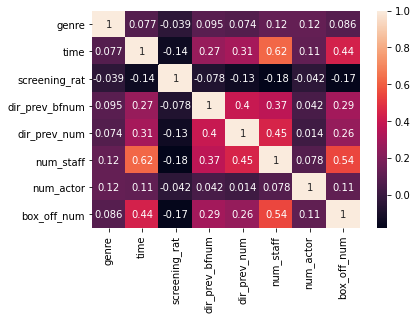

In [ ]:
#annot cell 값 표기여부 옵션
sns.heatmap(train.corr(), annot=True)

In [ ]:
features = ['time','dir_prev_num','num_staff','num_staff','dir_prev_bfnum','genre','screening_rat'] 
target = ['box_off_num']

In [ ]:
X_train , X_test, y_train = train[features],test[features],train[target]

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
k_fold = KFold(n_splits=5,shuffle=True, random_state=111)

In [ ]:
# 하이퍼파라미터 (커널스케일, 박스컨스트레인트 등 모델파라미터를 의미) 의 최적값을 찾음
from sklearn.model_selection import GridSearchCV

In [ ]:
model = lgb.LGBMRegressor(random_state=111,objective = 'regression_l2',metric='rmse',boosting_type='dart')
#learning_rate: 기존모델의 성능을 다음 모델에 얼만큼 영향을 줄것인지 가중치. 값이 적을수록 미세한영향
#min_child_samples : 최종 결정 클래스인 Leaf Node가 되기 위해서 최소한으로 필요한 데이터 개체의 수
params = { 
    'learning_rate' : [0.003,0.004,0.005,0.0006],
    'min_child_samples' :[25,30,35,45,60] ,
    'n_estimators' : [600,700,800,900,1000],
    'max_depth ' :  [10,20,30,40]
    
    }
# 대회에서는 RMSE 가 평가지표이므로 scoring 을 neg_mean_squared_error 로 설정
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  scoring = 'neg_mean_squared_error',
                  cv=k_fold) # 일반적으로 kfold를 사용하고 cv=5 해도 동일


In [ ]:
gs.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='dart', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, metric='rmse',
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective='re...
                                     reg_lambda=0.0, silent=True, subsample=1.0,
                                     subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.003, 0.004, 0.005, 0.0006],
                         'm

In [ ]:
gs.best_params_

{'learning_rate': 0.005,
 'max_depth ': 10,
 'min_child_samples': 25,
 'n_estimators': 1000}

In [ ]:
model=lgb.LGBMRegressor(random_state=111,max_depth=10,n_estimators=1000,learning_rate= 0.005, min_child_samples= 25,objective = 'regression_l2',metric='rmse')

models = []

# n_splits=5 이므로 5번 반복
# iloc : index로 접근 X_train.iloc[train_idx] : X_train의 train_idx 값에 해당하는 행
for train_idx,val_idx in k_fold.split(X_train):
  x_t = X_train.iloc[train_idx]
  y_t = y_train.iloc[train_idx]
  x_val = X_train.iloc[val_idx]
  y_val = y_train.iloc[val_idx]
  
  #eval_set : 검증용 set ,early_stopping_rounds : 과적합을 막기위해 어느단계에서 멈출지, n_estimators 만큼 반복하는데 early_stopping_rounds 만큼 성능의 증가(오차율감소)가 없다면 멈춤
  # verbose= 해당숫자만큼 진행했을때 진행과정 출력
  models.append(model.fit(x_t,y_t,eval_set=(x_val,y_val),early_stopping_rounds=100,verbose=100))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.39086e+06
[200]	valid_0's rmse: 1.29709e+06
[300]	valid_0's rmse: 1.26282e+06
[400]	valid_0's rmse: 1.24287e+06
[500]	valid_0's rmse: 1.21744e+06
[600]	valid_0's rmse: 1.2123e+06
[700]	valid_0's rmse: 1.20216e+06
[800]	valid_0's rmse: 1.19724e+06
[900]	valid_0's rmse: 1.19492e+06
[1000]	valid_0's rmse: 1.19493e+06
Did not meet early stopping. Best iteration is:
[914]	valid_0's rmse: 1.19408e+06
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.32211e+06
[200]	valid_0's rmse: 1.24286e+06
[300]	valid_0's rmse: 1.22198e+06
[400]	valid_0's rmse: 1.21843e+06
Early stopping, best iteration is:
[368]	valid_0's rmse: 1.21681e+06
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 1.50327e+06
[200]	valid_0's rmse: 1.45786e+06
[300]	valid_0's rmse: 1.45192e+06
Early stopping, best iteration is:
[271]	valid_0's rmse: 1.44763e+06
Training unti

In [ ]:
preds = []
for model in models:
  preds.append(model.predict(X_test))


In [ ]:
import numpy as np
gsLGBM = submission.copy()
gsLGBM['box_off_num'] = np.mean(preds,axis=0)

In [ ]:
gsLGBM.to_csv('gsLGBM_1000_0005_25_10_l2_rmse.csv',index=False)